# Homework 03: Learning Curves and Training Workflow

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

In this homework, you will use **early stopping** to select the "best" model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance. Test accuracy is reported for reference but is not used for model selection.

> **Note:** Throughout this homework, best always refers to the model selected by early stopping at the epoch of minimum validation loss. Do not report metrics from the final training epoch unless explicitly instructed.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


2026-02-06 21:45:20.378575: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-06 21:45:20.425298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-06 21:45:22.949453: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [3]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [4]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This data set is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [5]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [6]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [7]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

2026-02-06 21:45:23.824416: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [8]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Baseline: ReLU



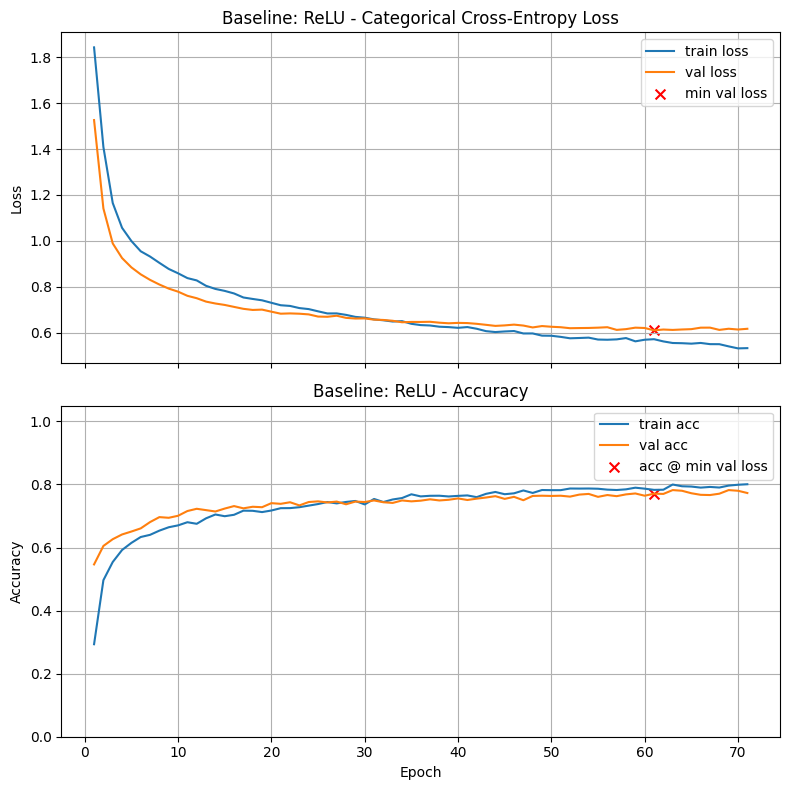

Final Training Loss:            0.5318
Final Training Accuracy:        0.8007
Final Validation Loss:          0.6162
Final Validation Accuracy:      0.7729
Minimum Validation Loss:        0.6094 (Epoch 61)
Validation Accuracy @ Min Loss: 0.7707

Test Loss: 0.6554
Test Accuracy: 0.7671

Validation-Test Gap (accuracy): 0.003571

Execution Time: 00:00:12

Baseline: Sigmoid



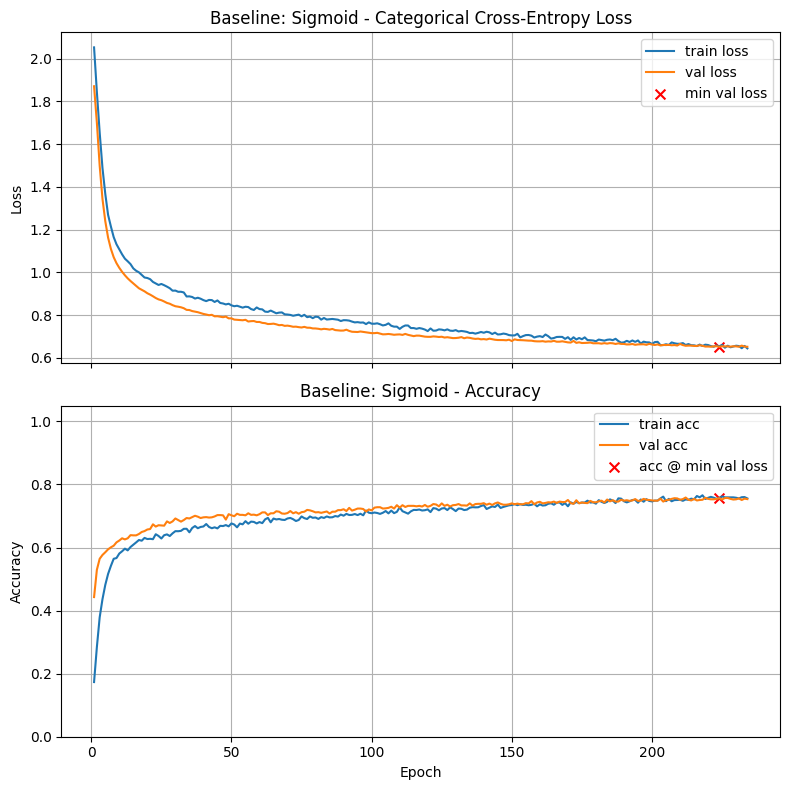

Final Training Loss:            0.6441
Final Training Accuracy:        0.7557
Final Validation Loss:          0.6517
Final Validation Accuracy:      0.7536
Minimum Validation Loss:        0.6515 (Epoch 224)
Validation Accuracy @ Min Loss: 0.7564

Test Loss: 0.6823
Test Accuracy: 0.7357

Validation-Test Gap (accuracy): 0.020714

Execution Time: 00:00:38

Baseline: Tanh



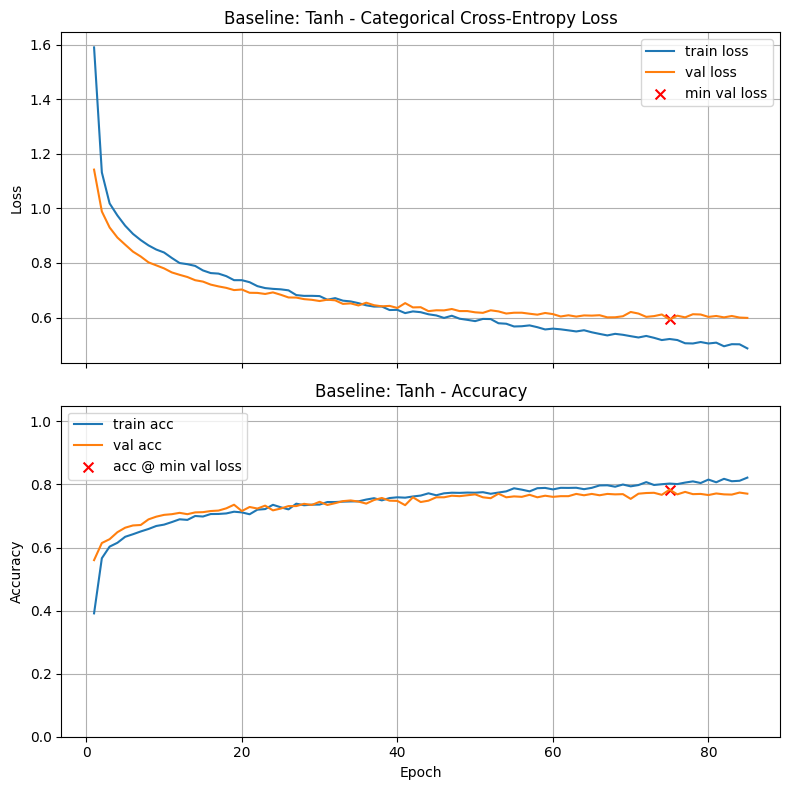

Final Training Loss:            0.4870
Final Training Accuracy:        0.8217
Final Validation Loss:          0.5986
Final Validation Accuracy:      0.7707
Minimum Validation Loss:        0.5929 (Epoch 75)
Validation Accuracy @ Min Loss: 0.7836

Test Loss: 0.6208
Test Accuracy: 0.7657

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:15


In [9]:
# Your code here. Add as many cells as you need. 
#use train_and_test to train, display results, and run test set
#use build_model to build model w/ required params
#create model named model_baseline
def model_baseline(activation, title):
    model = build_model(X_train.shape[-1], [(64, activation, 0.0,0.0), (32, activation,0.001, 0.3)], n_classes)
    return train_and_test(model, title=title)

results={}
model_baseline('relu', title='Baseline: ReLU')
model_baseline('sigmoid', title='Baseline: Sigmoid')
model_baseline('tanh', title='Baseline: Tanh')

In [10]:
#find highest valid. accuracy
best_title, (best_acc, best_epoch) = max(results.items(), key=lambda kv: kv[1][0])
print("Best model:", best_title)
print("Best validation accuracy:", best_acc)
print("Best epoch:", best_epoch)

Best model: Baseline: Tanh
Best validation accuracy: 0.7835714221000671
Best epoch: 75


In [11]:
#save best acitvation
best_activation = 'tanh'
best_activation

'tanh'

### Graded Questions

In [13]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 2             # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [14]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 2


In [15]:
# Set a1b to the validation accuracy found by this best activation function

a1b = best_acc             # Replace 0.0 with your answer

In [16]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7836


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



Baseline: 0.001



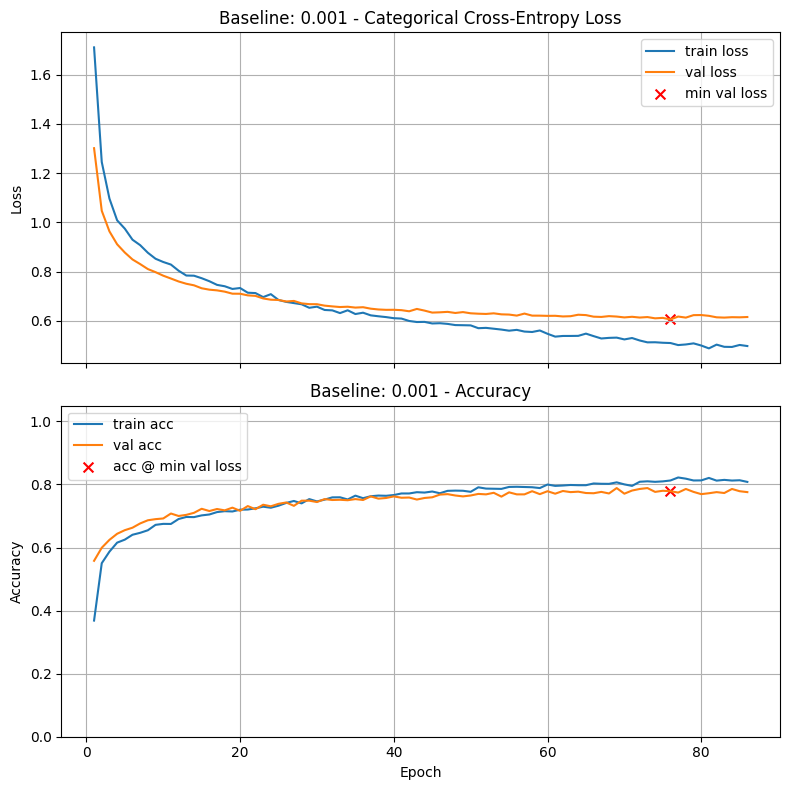

Final Training Loss:            0.4981
Final Training Accuracy:        0.8081
Final Validation Loss:          0.6160
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.6060 (Epoch 76)
Validation Accuracy @ Min Loss: 0.7786

Test Loss: 0.6149
Test Accuracy: 0.7736

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:00:21

Baseline: 0.0005



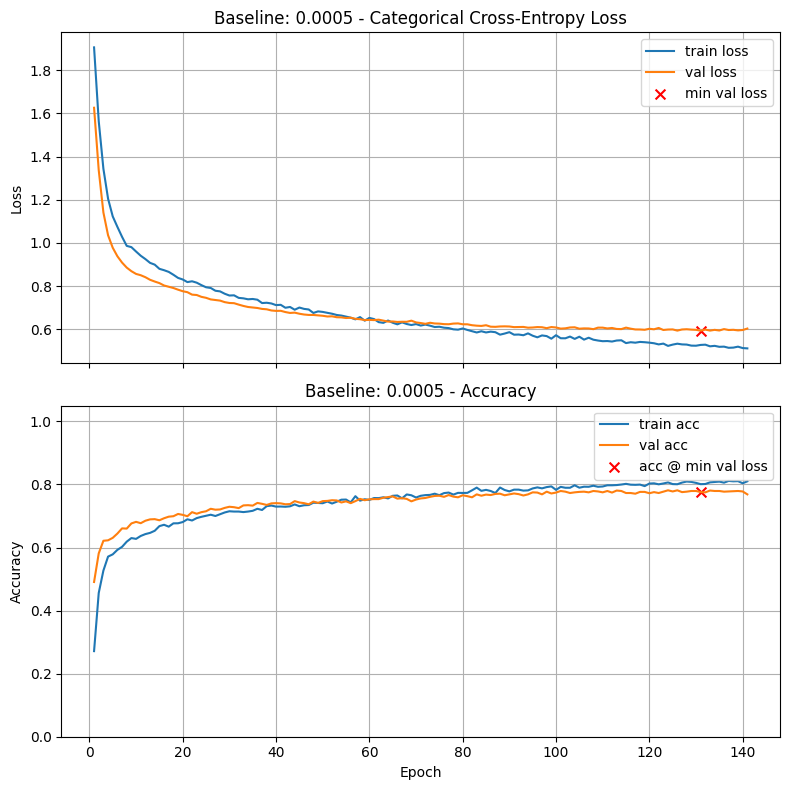

Final Training Loss:            0.5111
Final Training Accuracy:        0.8100
Final Validation Loss:          0.6030
Final Validation Accuracy:      0.7686
Minimum Validation Loss:        0.5932 (Epoch 131)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.6195
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:00:24

Baseline: 0.0001



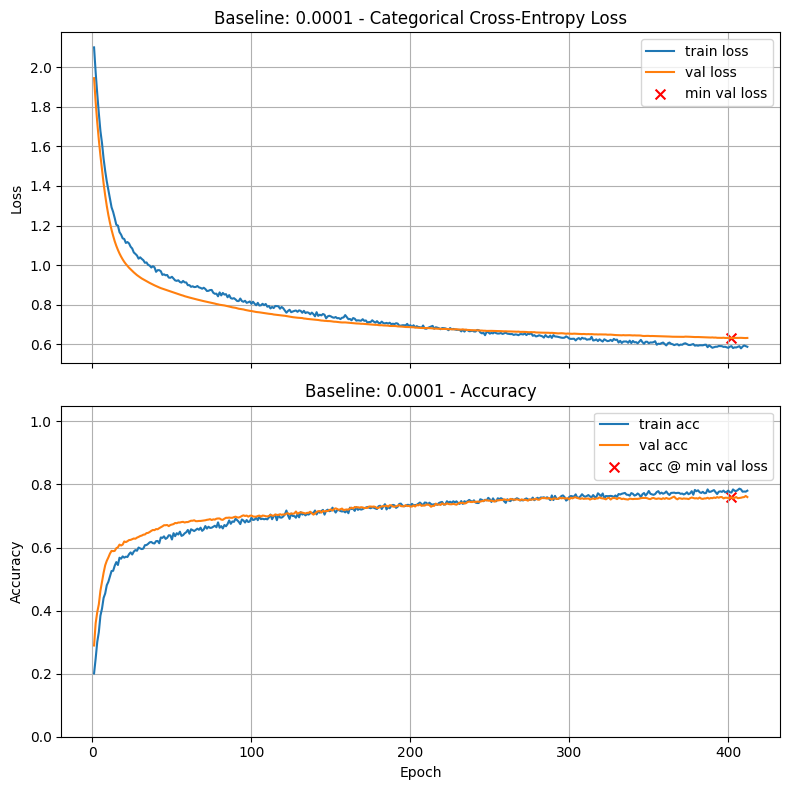

Final Training Loss:            0.5868
Final Training Accuracy:        0.7802
Final Validation Loss:          0.6316
Final Validation Accuracy:      0.7600
Minimum Validation Loss:        0.6308 (Epoch 402)
Validation Accuracy @ Min Loss: 0.7600

Test Loss: 0.6429
Test Accuracy: 0.7636

Validation-Test Gap (accuracy): 0.003571

Execution Time: 00:01:07

Baseline: 5e-05



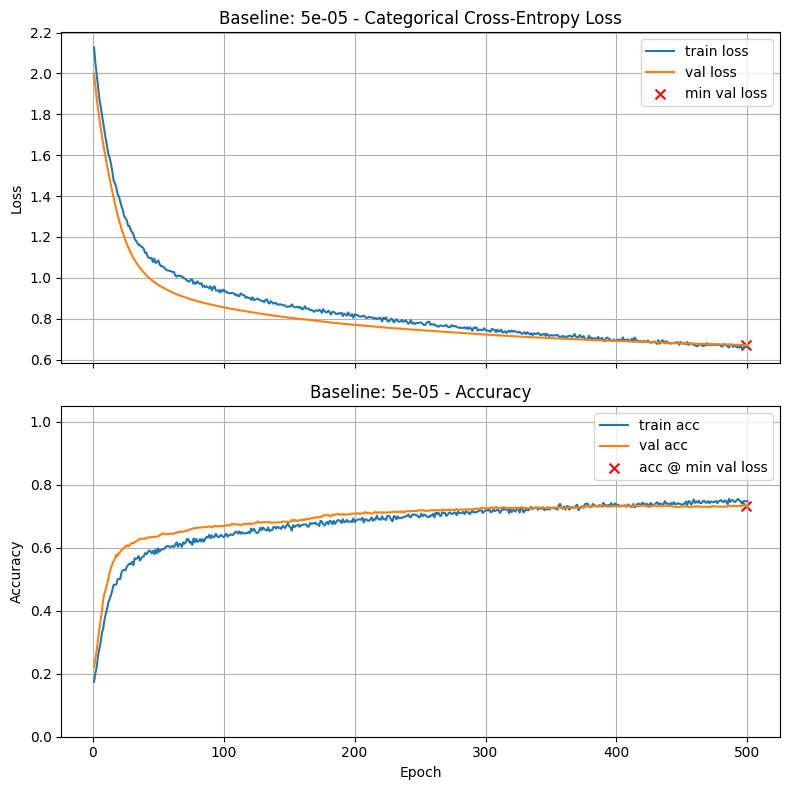

Final Training Loss:            0.6614
Final Training Accuracy:        0.7481
Final Validation Loss:          0.6713
Final Validation Accuracy:      0.7329
Minimum Validation Loss:        0.6712 (Epoch 499)
Validation Accuracy @ Min Loss: 0.7329

Test Loss: 0.6851
Test Accuracy: 0.7329

Validation-Test Gap (accuracy): 0.003571

Execution Time: 00:01:21

Baseline: 1e-05



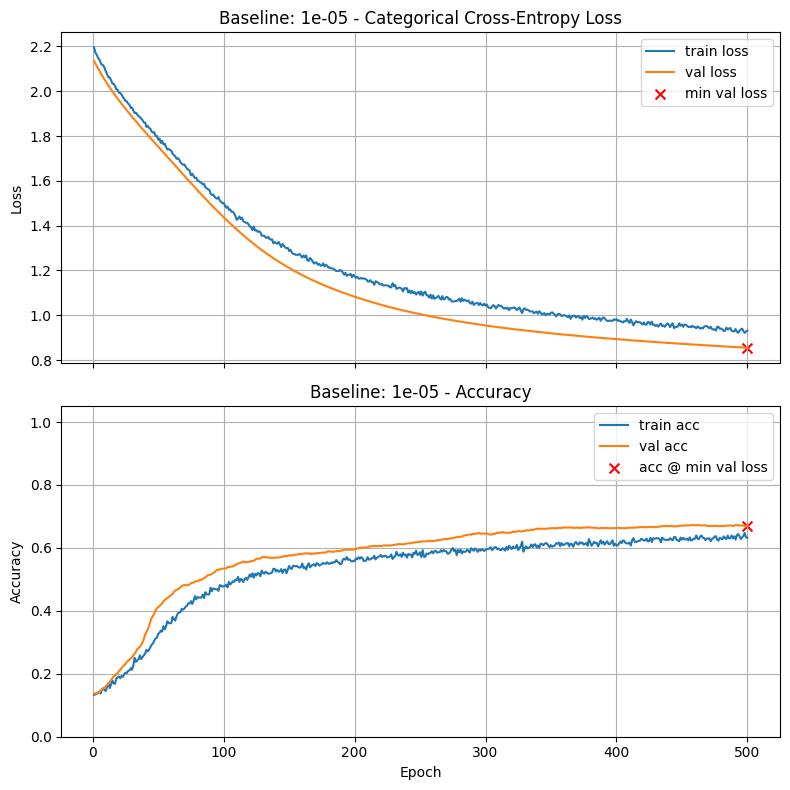

Final Training Loss:            0.9315
Final Training Accuracy:        0.6324
Final Validation Loss:          0.8547
Final Validation Accuracy:      0.6693
Minimum Validation Loss:        0.8547 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6693

Test Loss: 0.8755
Test Accuracy: 0.6786

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:01:21


In [17]:
# Your code here. Add as many cells as you need. 
lrs = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5] #learning rates given above

#create baseline model func w/learning rate
def base_model_lr(lr, title):
    model = build_model(X_train.shape[-1], [(64, 'relu', 0.0,0.0), (32, 'relu',0.001, 0.3)], n_classes)
    return train_and_test(model, lr_schedule=lr, title=title)

#run using for loop and store results
results = {} #reset results
for lr in lrs:
    title = f"Baseline: {lr}"
    base_model_lr(lr, title)

In [18]:
#find best learning rate and valid. accuracy
best_title, (best_acc, best_epoch) = max(results.items(), key=lambda kv: kv[1][0])
print("Best run:", best_title)
print("Best val accuracy:", best_acc)
print("Best epoch:", best_epoch)

Best run: Baseline: 0.001
Best val accuracy: 0.7785714268684387
Best epoch: 76


In [19]:
#save best learning rate
best_lr = 1e-3
best_lr

0.001

#### Graded Questions

In [20]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 1e-3           # Replace 0.0 with your answer

In [21]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.001000


In [22]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = best_acc             # Replace 0.0 with your answer

In [23]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7786


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Dropout d1=0.0, d2=0.3



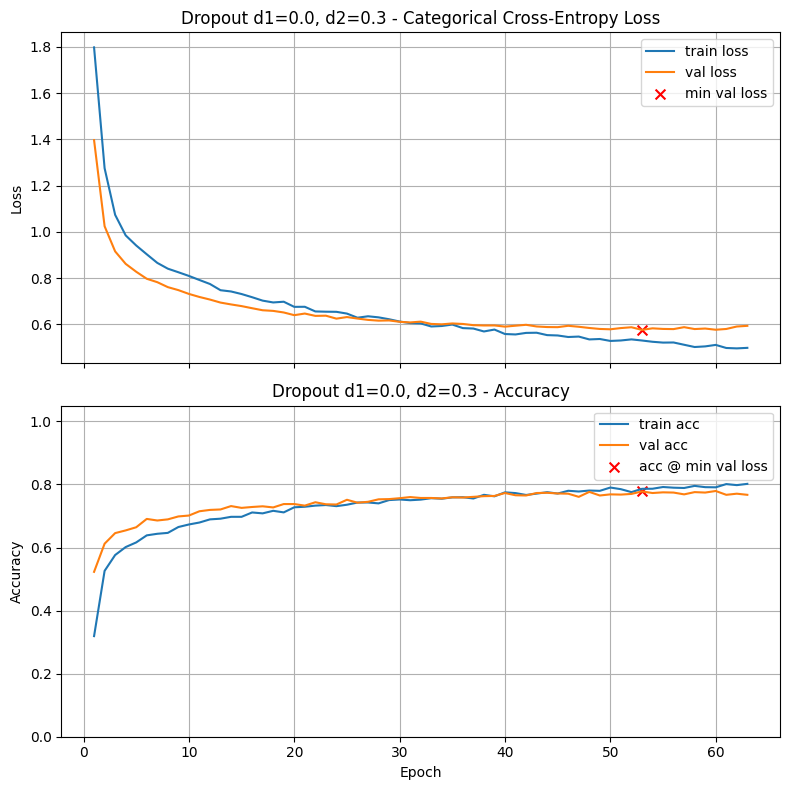

Final Training Loss:            0.4979
Final Training Accuracy:        0.8019
Final Validation Loss:          0.5932
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.5757 (Epoch 53)
Validation Accuracy @ Min Loss: 0.7779

Test Loss: 0.6142
Test Accuracy: 0.7593

Validation-Test Gap (accuracy): 0.018571

Execution Time: 00:00:11

Dropout d1=0.0, d2=0.4



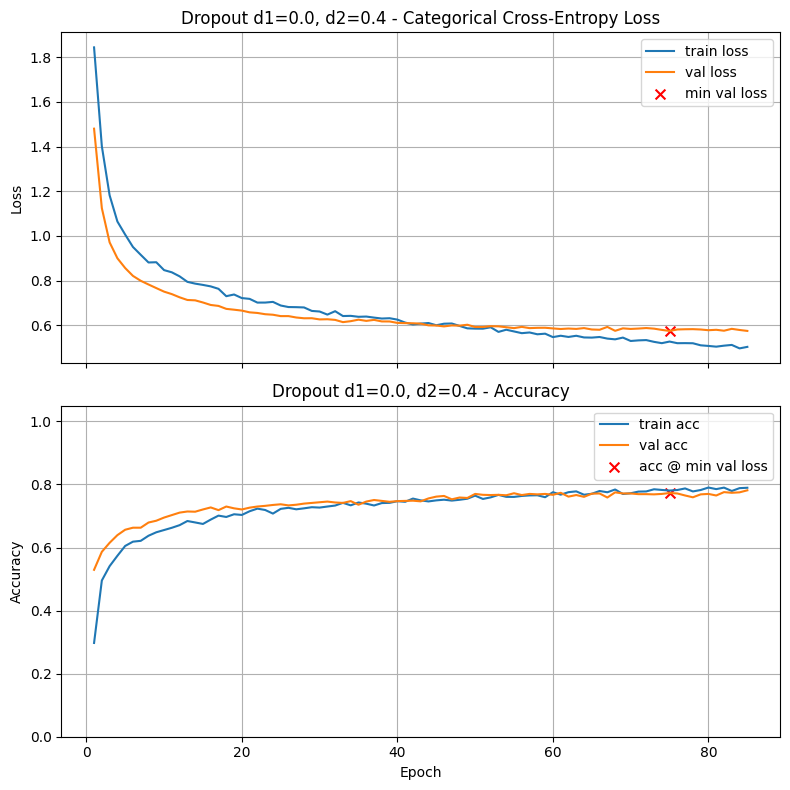

Final Training Loss:            0.5034
Final Training Accuracy:        0.7895
Final Validation Loss:          0.5748
Final Validation Accuracy:      0.7814
Minimum Validation Loss:        0.5746 (Epoch 75)
Validation Accuracy @ Min Loss: 0.7729

Test Loss: 0.5854
Test Accuracy: 0.7671

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:14

Dropout d1=0.0, d2=0.5



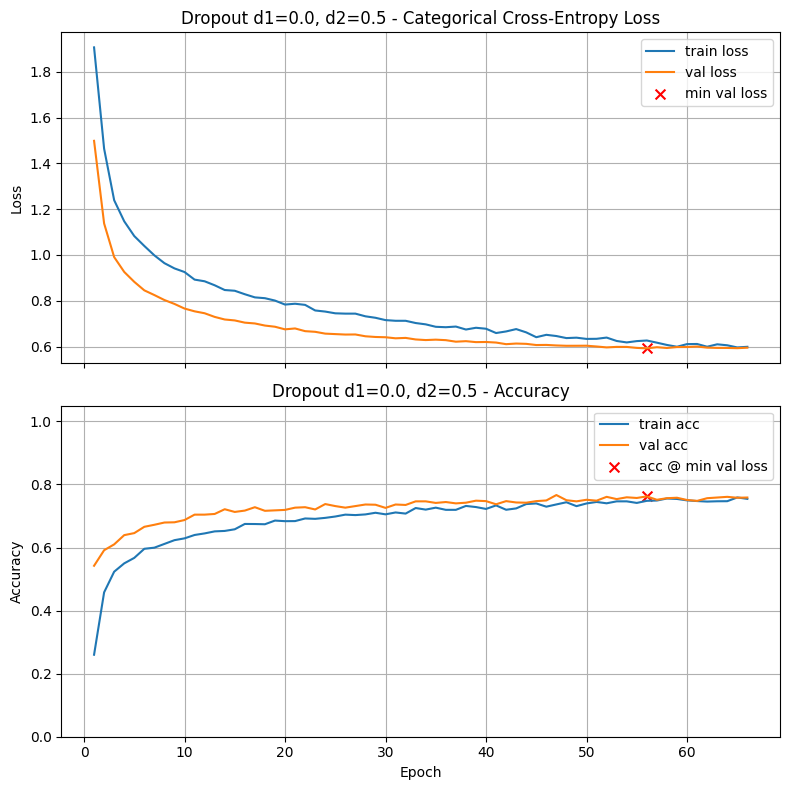

Final Training Loss:            0.5991
Final Training Accuracy:        0.7543
Final Validation Loss:          0.5952
Final Validation Accuracy:      0.7586
Minimum Validation Loss:        0.5922 (Epoch 56)
Validation Accuracy @ Min Loss: 0.7621

Test Loss: 0.6143
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.003571

Execution Time: 00:00:11

Dropout d1=0.1, d2=0.3



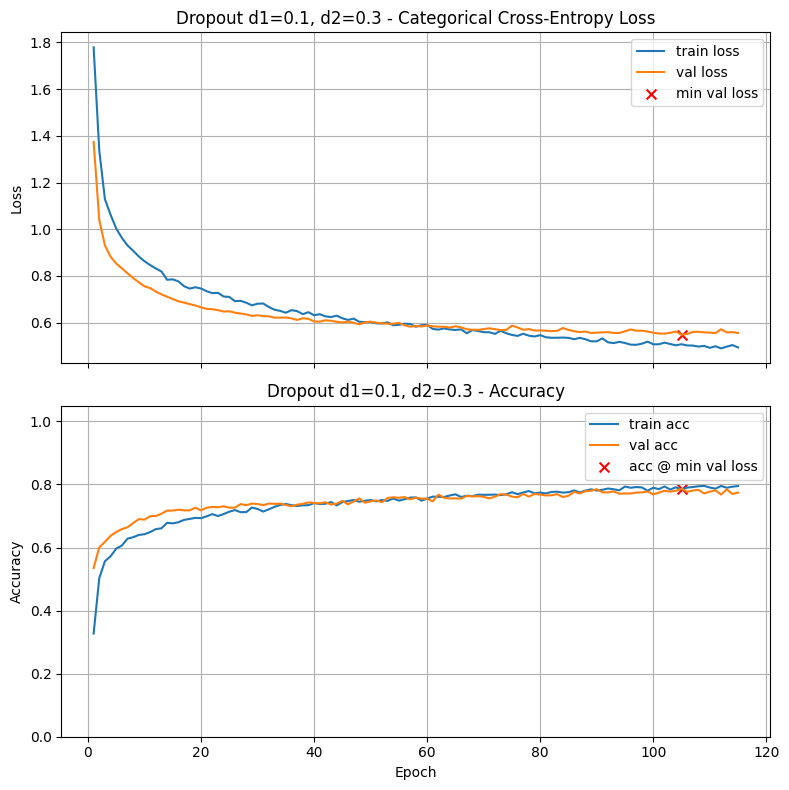

Final Training Loss:            0.4941
Final Training Accuracy:        0.7950
Final Validation Loss:          0.5562
Final Validation Accuracy:      0.7743
Minimum Validation Loss:        0.5490 (Epoch 105)
Validation Accuracy @ Min Loss: 0.7864

Test Loss: 0.5880
Test Accuracy: 0.7779

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:00:20

Dropout d1=0.1, d2=0.4



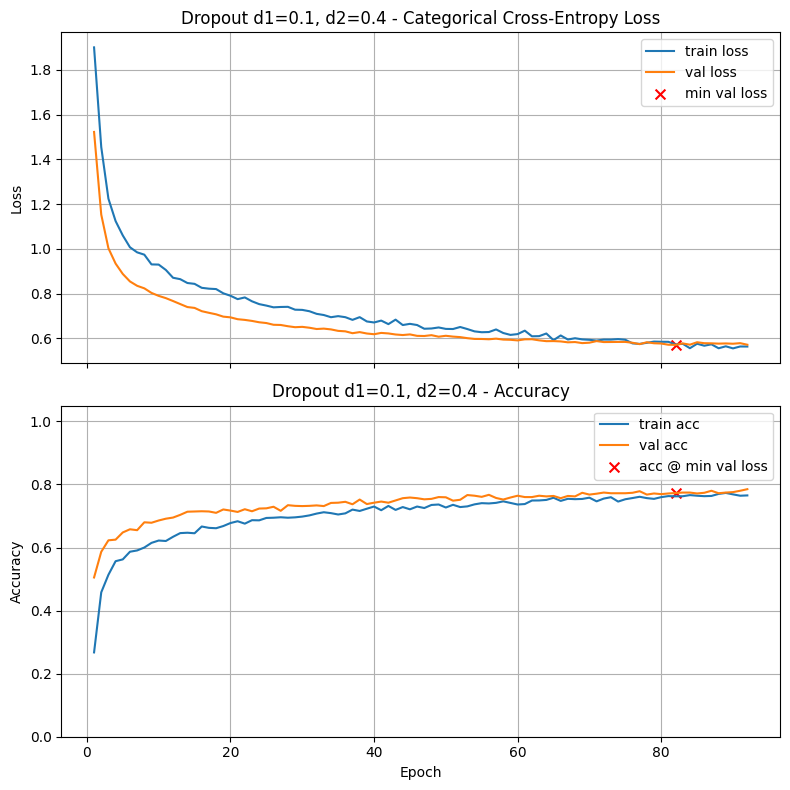

Final Training Loss:            0.5636
Final Training Accuracy:        0.7652
Final Validation Loss:          0.5716
Final Validation Accuracy:      0.7850
Minimum Validation Loss:        0.5710 (Epoch 82)
Validation Accuracy @ Min Loss: 0.7729

Test Loss: 0.6018
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.018571

Execution Time: 00:00:16

Dropout d1=0.1, d2=0.5



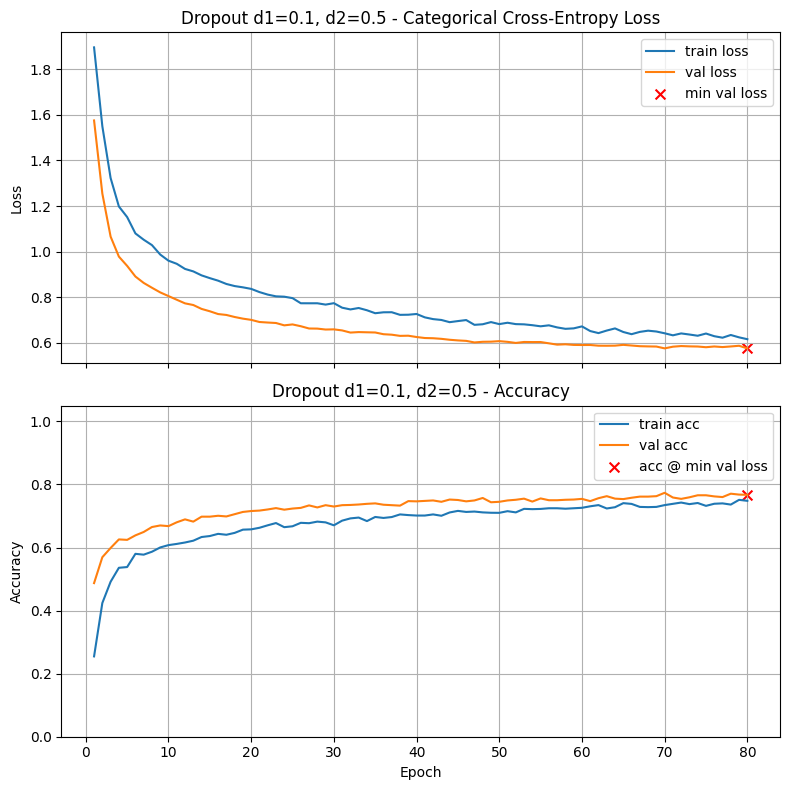

Final Training Loss:            0.6167
Final Training Accuracy:        0.7481
Final Validation Loss:          0.5764
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.5764 (Epoch 80)
Validation Accuracy @ Min Loss: 0.7671

Test Loss: 0.6166
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:14

Dropout d1=0.2, d2=0.3



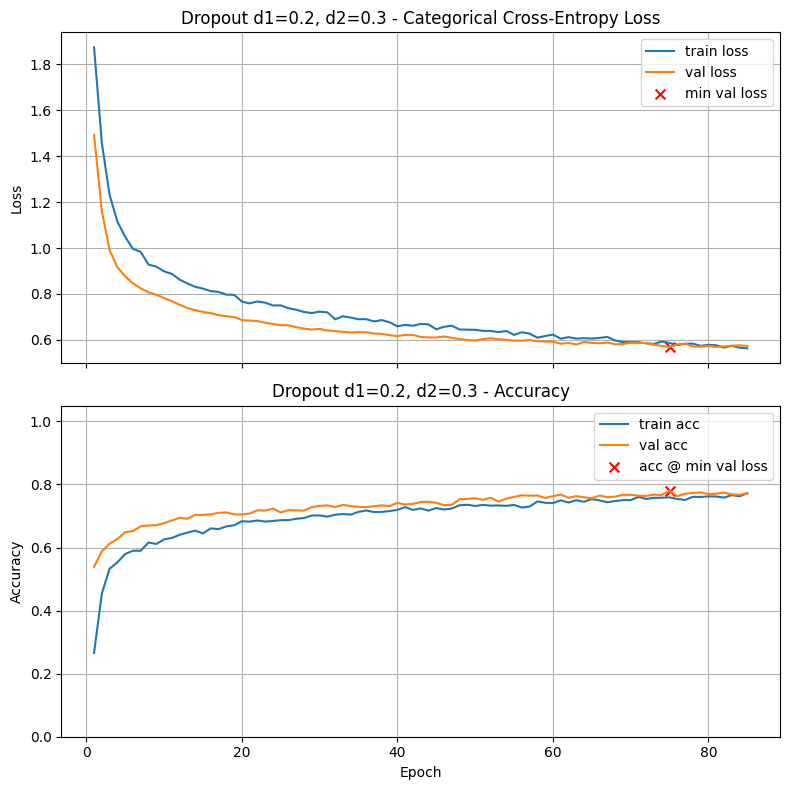

Final Training Loss:            0.5631
Final Training Accuracy:        0.7724
Final Validation Loss:          0.5738
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.5691 (Epoch 75)
Validation Accuracy @ Min Loss: 0.7800

Test Loss: 0.6064
Test Accuracy: 0.7600

Validation-Test Gap (accuracy): 0.020000

Execution Time: 00:00:15

Dropout d1=0.2, d2=0.4



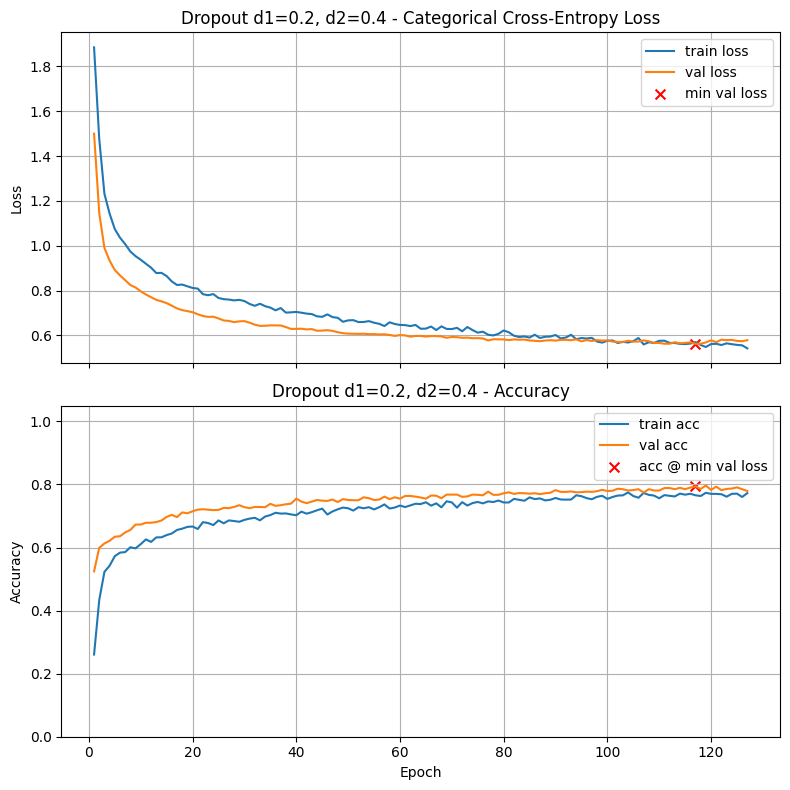

Final Training Loss:            0.5419
Final Training Accuracy:        0.7726
Final Validation Loss:          0.5783
Final Validation Accuracy:      0.7793
Minimum Validation Loss:        0.5621 (Epoch 117)
Validation Accuracy @ Min Loss: 0.7943

Test Loss: 0.6243
Test Accuracy: 0.7636

Validation-Test Gap (accuracy): 0.030714

Execution Time: 00:00:21

Dropout d1=0.2, d2=0.5



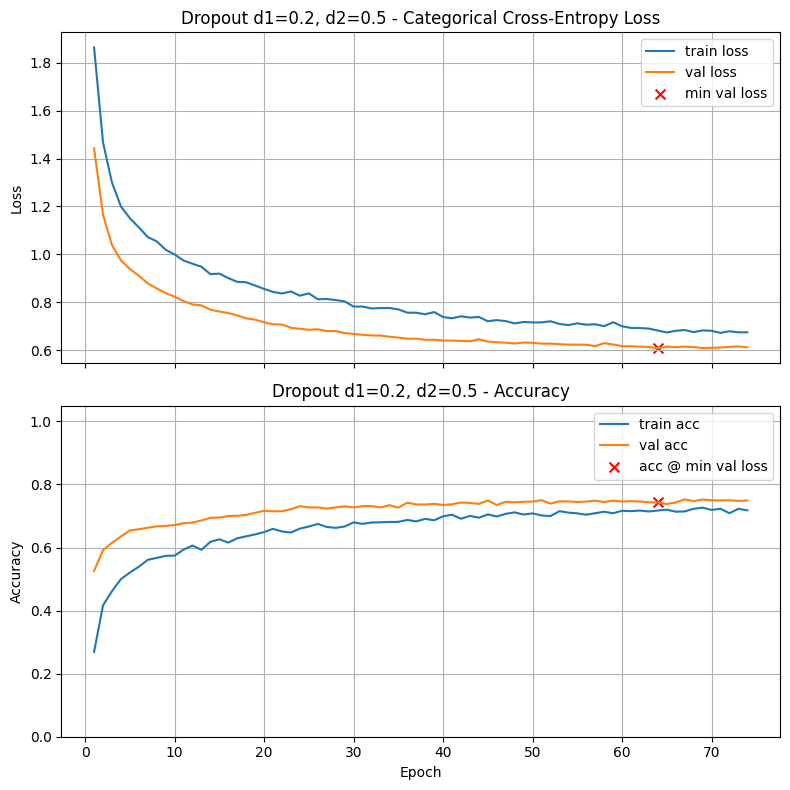

Final Training Loss:            0.6741
Final Training Accuracy:        0.7179
Final Validation Loss:          0.6114
Final Validation Accuracy:      0.7493
Minimum Validation Loss:        0.6070 (Epoch 64)
Validation Accuracy @ Min Loss: 0.7429

Test Loss: 0.6292
Test Accuracy: 0.7486

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:13


In [24]:
# Your code here. Add as many cells as you need. 
#from problems 1&2 use: relu, learning rate = 1e-3
dropouts_64 = [0.0, 0.1, 0.2] #for earlier layers, use smaller dropout
dropouts_32 = [0.3, 0.4, 0.5] #for later layers, use larger dropout vals
#create function to run diff dropouts on
def baseline_mod_do(d1, d2, title):
    model = build_model(X_train.shape[-1], [(64, 'relu', 0.0, d1), (32, 'relu', 0.0, d2)], n_classes)
    return train_and_test(model, lr_schedule=1e-3, title=title)

#for loop to run over each val.
for d1 in dropouts_64:
    for d2 in dropouts_32:
        title=f"Dropout d1={d1}, d2={d2}"
        baseline_mod_do(d1, d2, title)

In [25]:
#find best dropout pair
best_title, (best_acc, best_epoch) = max(results.items(), key=lambda kv: kv[1][0])
print("Best run:", best_title)
print("Best val. accuracy:", best_acc)

Best run: Dropout d1=0.2, d2=0.4
Best val. accuracy: 0.7942857146263123


In [26]:
#save drop out results
best_d1 = 0.2
best_d2 = 0.4
(best_d1, best_d2)

(0.2, 0.4)

In [27]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = (0.2,0.4)             # Replace (0.0,0.0) with your answer

In [28]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.2, 0.4)


In [29]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = best_acc             # Replace 0.0 with your answer

In [30]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7943


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



L2 l1=0.0001, l2=0.0001



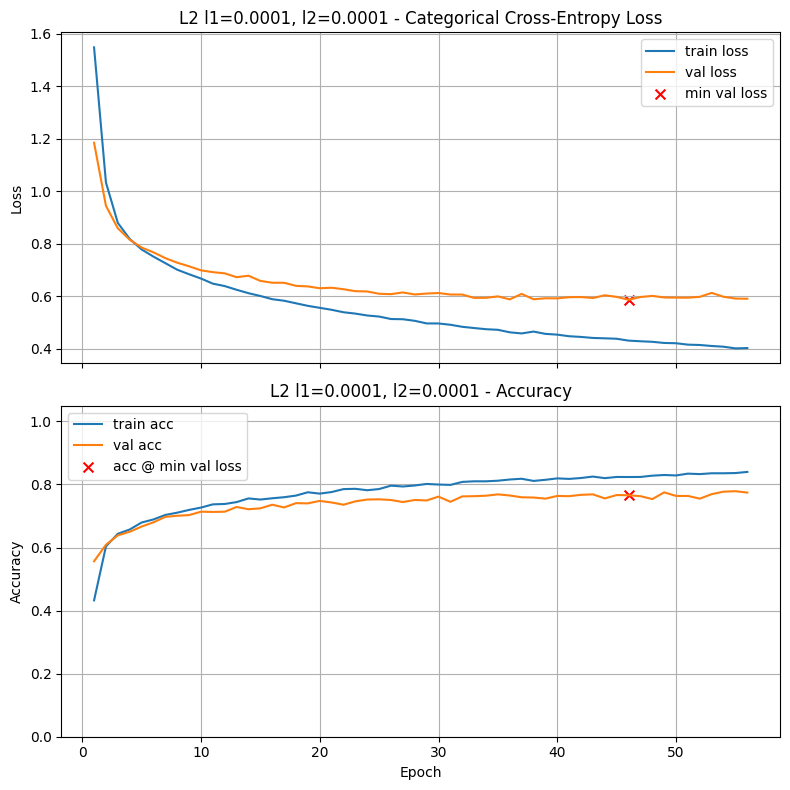

Final Training Loss:            0.4021
Final Training Accuracy:        0.8398
Final Validation Loss:          0.5901
Final Validation Accuracy:      0.7743
Minimum Validation Loss:        0.5859 (Epoch 46)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.6146
Test Accuracy: 0.7521

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:11

L2 l1=0.001, l2=0.001



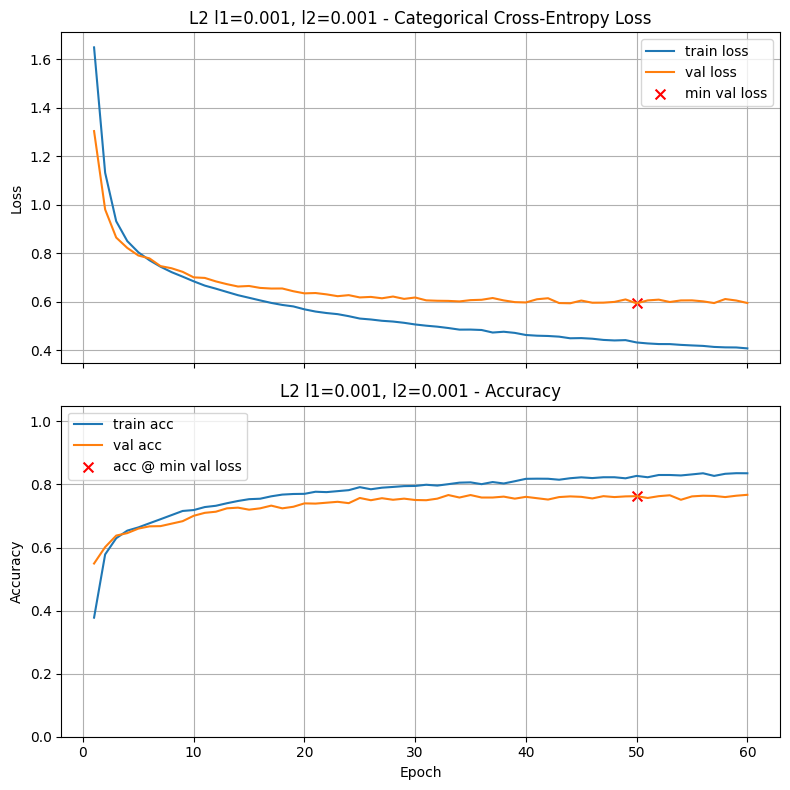

Final Training Loss:            0.4085
Final Training Accuracy:        0.8355
Final Validation Loss:          0.5954
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.5940 (Epoch 50)
Validation Accuracy @ Min Loss: 0.7629

Test Loss: 0.6090
Test Accuracy: 0.7486

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:00:11

L2 l1=0.01, l2=0.01



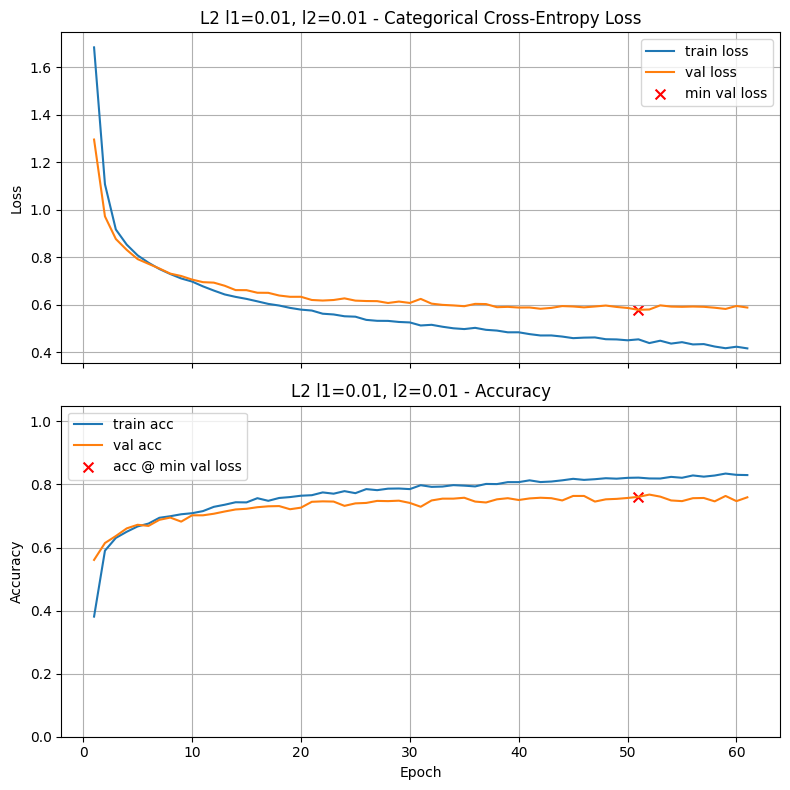

Final Training Loss:            0.4156
Final Training Accuracy:        0.8298
Final Validation Loss:          0.5876
Final Validation Accuracy:      0.7593
Minimum Validation Loss:        0.5780 (Epoch 51)
Validation Accuracy @ Min Loss: 0.7607

Test Loss: 0.6038
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:00:12

L2 l1=0.0001, l2=0.001



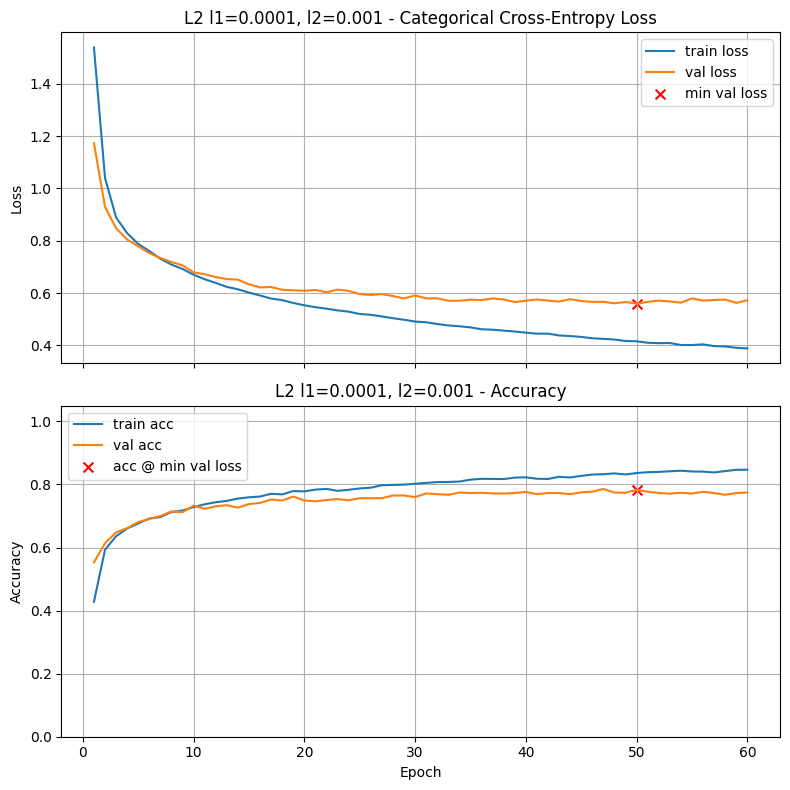

Final Training Loss:            0.3883
Final Training Accuracy:        0.8469
Final Validation Loss:          0.5726
Final Validation Accuracy:      0.7743
Minimum Validation Loss:        0.5592 (Epoch 50)
Validation Accuracy @ Min Loss: 0.7829

Test Loss: 0.5821
Test Accuracy: 0.7721

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:11


In [31]:
# Your code here. Add as many cells as you need. 
#use best variables from prev. problems
l2_vals = [(1e-4, 1e-4), (1e-3, 1e-3), (1e-2, 1e-2), (1e-4, 1e-3)]
#create function to run diff dropouts on
def baseline_mod_l2(l2_1, l2_2, title):
    model = build_model(X_train.shape[-1], [(64, 'relu', l2_1, 0.1), (32, 'relu', l2_2, 0.3)], n_classes)
    return train_and_test(model, lr_schedule=1e-3, title=title)

#for loop to run over each val.
results = {} #store results
for (l2_1, l2_2) in l2_vals:
    title=f"L2 l1={l2_1}, l2={l2_2}"
    baseline_mod_do(l2_1, l2_2, title)

In [32]:
#find best vals
best_title, (best_acc, best_epoch) = max(results.items(), key=lambda kv: kv[1][0])
print("Best run:", best_title)
print("Best val. accuracy:", best_acc)

Best run: L2 l1=0.0001, l2=0.001
Best val. accuracy: 0.7828571200370789


In [33]:
#save l2 values
p4_l2_1 = 1e-4
p4_l2_2 = 1e-3
p4_best_acc = best_acc
print(p4_l2_1, p4_l2_2)
p4_best_acc

0.0001 0.001


0.7828571200370789

In [34]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (1e-4,1e-3)             # Replace (0.0,0.0) with your answer

In [35]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.0001, 0.001)


In [36]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = best_acc             # Replace 0.0 with your answer

In [37]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7829


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



In [38]:
# Your code here. Add as many cells as you need.
best_activation = 'relu' #activation func. from 1 = relu
best_lr = 1e-3 #lr from 2 = 1e-3
best_d1 = 0.1 
best_d2 = 0.3 #dropout from 3 = (0.1, 0.3)
l2_values = [1e-4, 1e-3, 1e-2] #given above
#define combos to test:
combos = []
#do baseline dropout and diff. L2
for l2 in l2_values:
    combos.append((best_d1, best_d2, l2, l2))
#slightly reduce dropout and L2
red_d1 = max(0.0, best_d1 - 0.1)
red_d2 = max(0.0, best_d2 - 0.1)
for l2 in l2_values:
    combos.append((red_d1, red_d2, l2, l2))
combos

[(0.1, 0.3, 0.0001, 0.0001),
 (0.1, 0.3, 0.001, 0.001),
 (0.1, 0.3, 0.01, 0.01),
 (0.0, 0.19999999999999998, 0.0001, 0.0001),
 (0.0, 0.19999999999999998, 0.001, 0.001),
 (0.0, 0.19999999999999998, 0.01, 0.01)]


Dropout + L2 d1=0.1, d2=0.3000, l2_1=0.0001, l2_2=0.0001



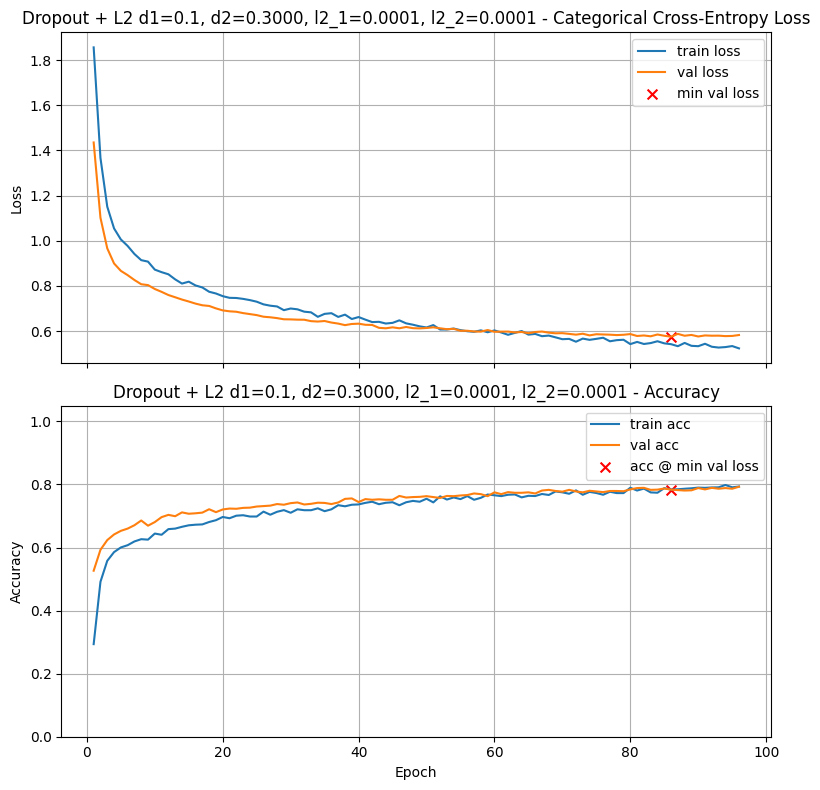

Final Training Loss:            0.5237
Final Training Accuracy:        0.7933
Final Validation Loss:          0.5829
Final Validation Accuracy:      0.7929
Minimum Validation Loss:        0.5755 (Epoch 86)
Validation Accuracy @ Min Loss: 0.7836

Test Loss: 0.6007
Test Accuracy: 0.7736

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:18

Dropout + L2 d1=0.1, d2=0.3000, l2_1=0.001, l2_2=0.001



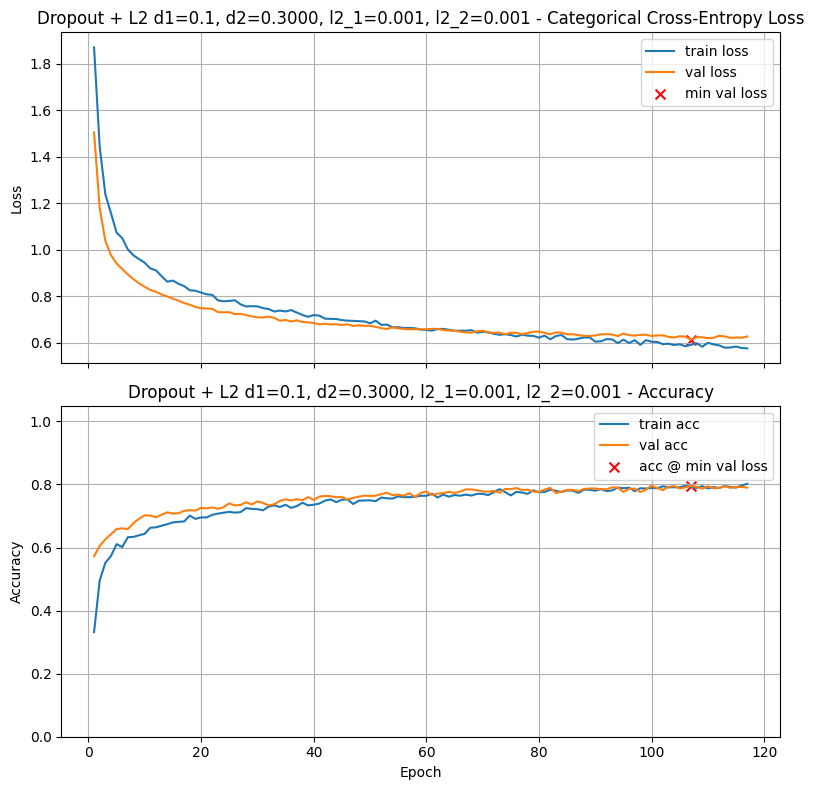

Final Training Loss:            0.5752
Final Training Accuracy:        0.8021
Final Validation Loss:          0.6263
Final Validation Accuracy:      0.7900
Minimum Validation Loss:        0.6133 (Epoch 107)
Validation Accuracy @ Min Loss: 0.7950

Test Loss: 0.6556
Test Accuracy: 0.7800

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:00:21

Dropout + L2 d1=0.1, d2=0.3000, l2_1=0.01, l2_2=0.01



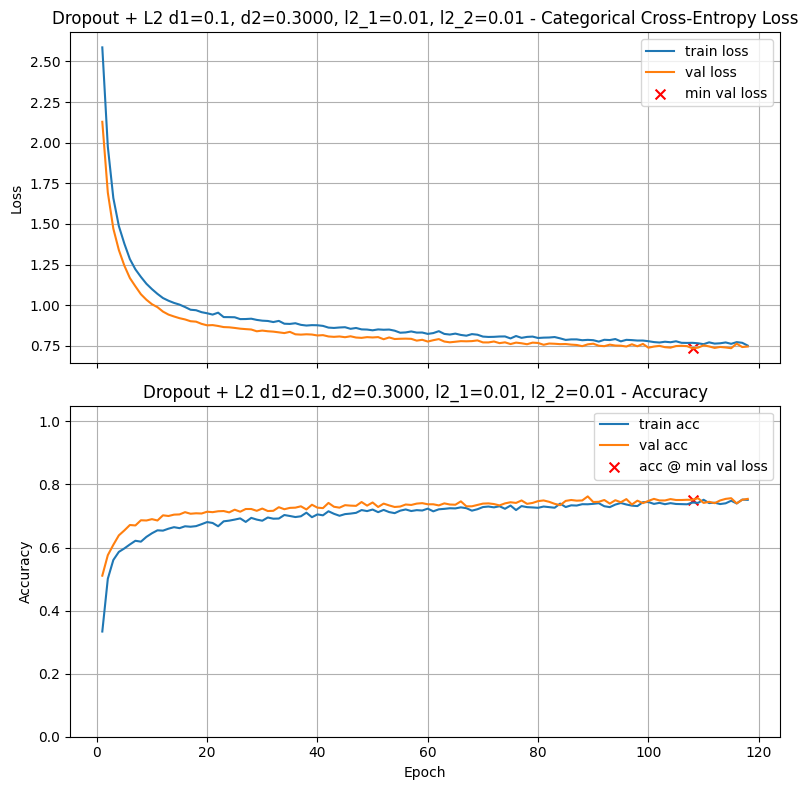

Final Training Loss:            0.7516
Final Training Accuracy:        0.7512
Final Validation Loss:          0.7460
Final Validation Accuracy:      0.7543
Minimum Validation Loss:        0.7345 (Epoch 108)
Validation Accuracy @ Min Loss: 0.7514

Test Loss: 0.7612
Test Accuracy: 0.7486

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:21

Dropout + L2 d1=0.0, d2=0.2000, l2_1=0.0001, l2_2=0.0001



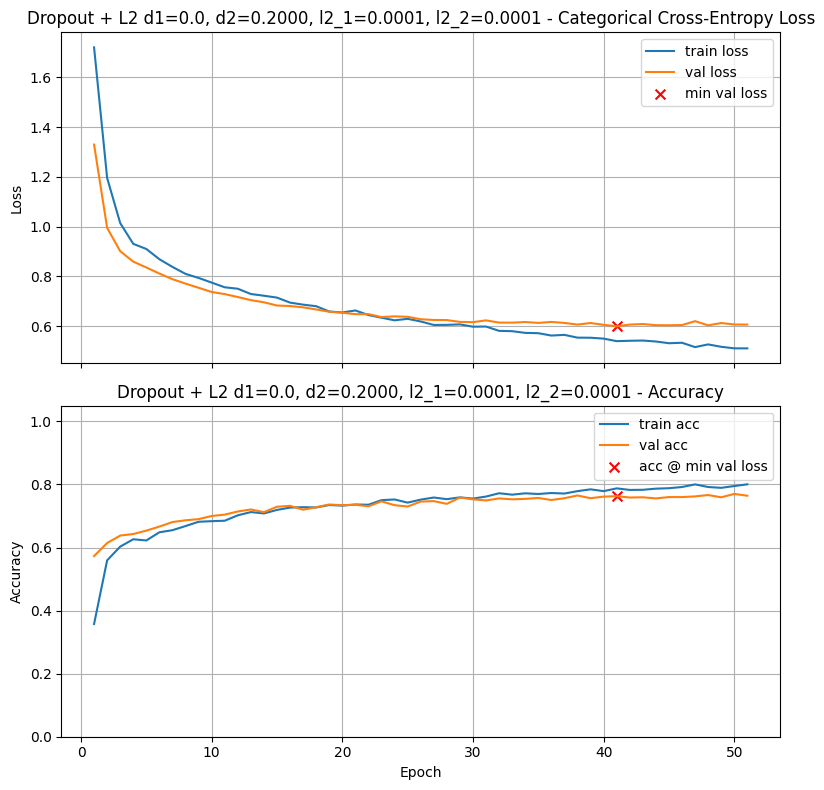

Final Training Loss:            0.5108
Final Training Accuracy:        0.8005
Final Validation Loss:          0.6064
Final Validation Accuracy:      0.7643
Minimum Validation Loss:        0.5994 (Epoch 41)
Validation Accuracy @ Min Loss: 0.7629

Test Loss: 0.6142
Test Accuracy: 0.7471

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:10

Dropout + L2 d1=0.0, d2=0.2000, l2_1=0.001, l2_2=0.001



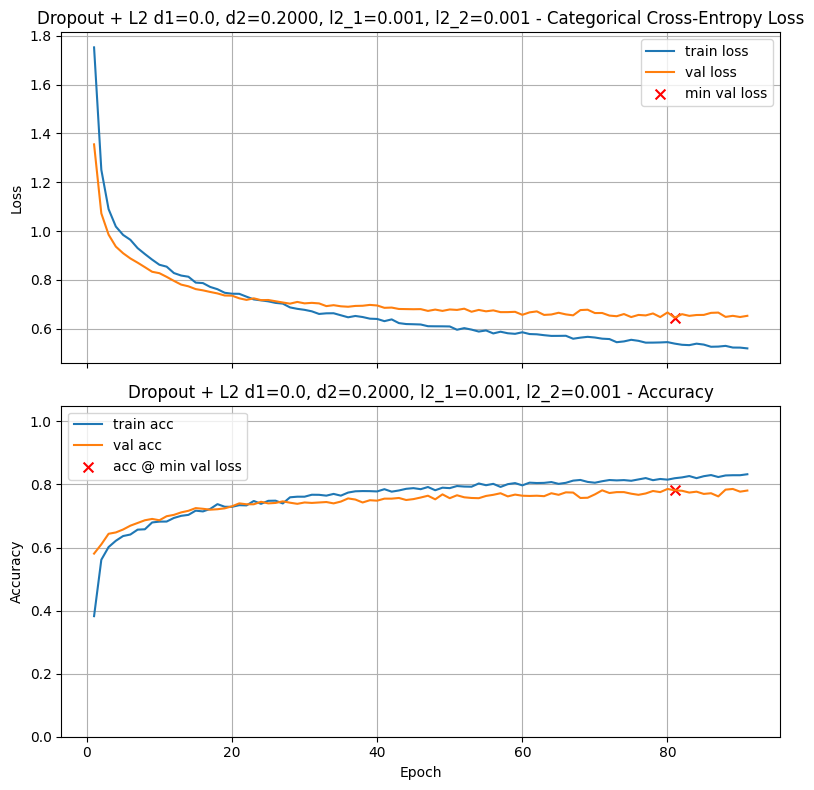

Final Training Loss:            0.5197
Final Training Accuracy:        0.8324
Final Validation Loss:          0.6531
Final Validation Accuracy:      0.7807
Minimum Validation Loss:        0.6455 (Epoch 81)
Validation Accuracy @ Min Loss: 0.7814

Test Loss: 0.6766
Test Accuracy: 0.7679

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:16

Dropout + L2 d1=0.0, d2=0.2000, l2_1=0.01, l2_2=0.01



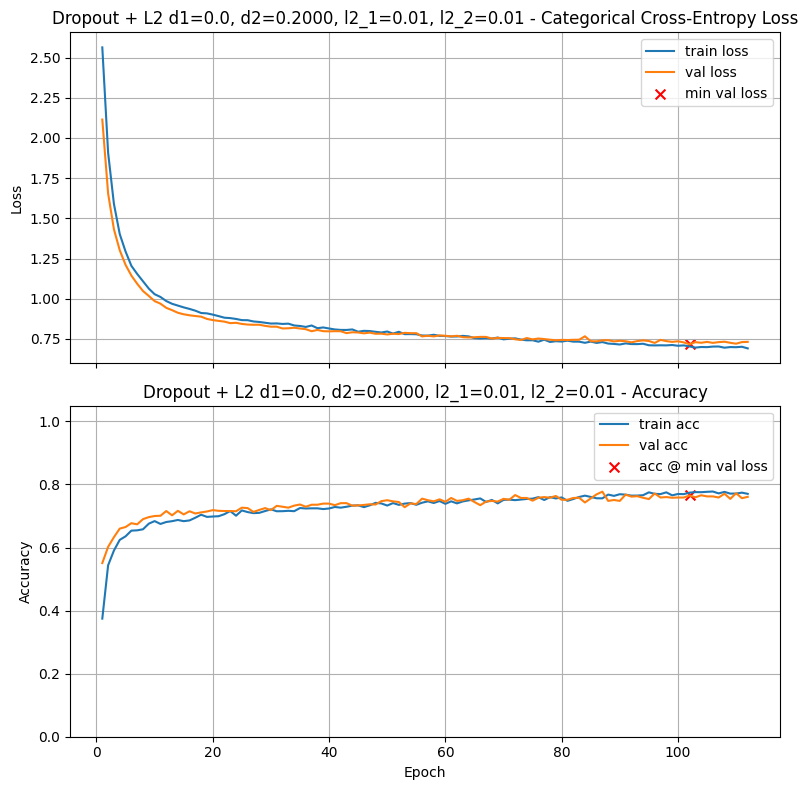

Final Training Loss:            0.6911
Final Training Accuracy:        0.7702
Final Validation Loss:          0.7316
Final Validation Accuracy:      0.7607
Minimum Validation Loss:        0.7168 (Epoch 102)
Validation Accuracy @ Min Loss: 0.7650

Test Loss: 0.7549
Test Accuracy: 0.7579

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:19


In [39]:
#build func. for drop out and L2 models
def base_do_l2(d1, d2, l2_1, l2_2, title):
    model = build_model(X_train.shape[-1], [(64, 'relu', l2_1, d1), (32, 'relu', l2_2, d2)], n_classes)
    return train_and_test(model, lr_schedule=best_lr, title=title)
results = {}
for (d1, d2, l2_1, l2_2) in combos:
    title = f"Dropout + L2 d1={d1}, d2={d2:.4f}, l2_1={l2_1}, l2_2={l2_2}"
    base_do_l2(d1, d2, l2_1, l2_2, title)

In [40]:
#find best combo
best_title, (best_acc, best_epoch) = max(results.items(), key=lambda kv: kv[1][0])
print("Best run:", best_title)
print("Best val accuracy:", best_acc)

Best run: Dropout + L2 d1=0.1, d2=0.3000, l2_1=0.001, l2_2=0.001
Best val accuracy: 0.7950000166893005


In [41]:
#save l2 values
p5_l2_1 = 1e-3
p5_l2_2 = 1e-3
p5_best_acc = best_acc
print(p5_l2_1, p5_l2_2)
p5_best_acc

0.001 0.001


0.7950000166893005

In [42]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = best_acc             # Replace 0.0 with your answer

In [43]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.7950


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.


In [44]:
#see which l2 (p4 or p5) has better val. accuracy
print(p4_best_acc)
print(p5_best_acc)

0.7828571200370789
0.7950000166893005


In [45]:
#p5 L2 vals had higher acc., redfine as best l2 vals
best_l2_1 = p5_l2_1
best_l2_2 = p5_l2_2

In [49]:
best_activation = 'tanh' #from problem 1

In [50]:
# Your code here
#best values from previous problems:
print("Activation:", best_activation)
print("LR:", best_lr)
print("Dropout:", best_d1, best_d2)
print("L2:", best_l2_1, best_l2_2) 

Activation: tanh
LR: 0.001
Dropout: 0.1 0.3
L2: 0.001 0.001



Best Model



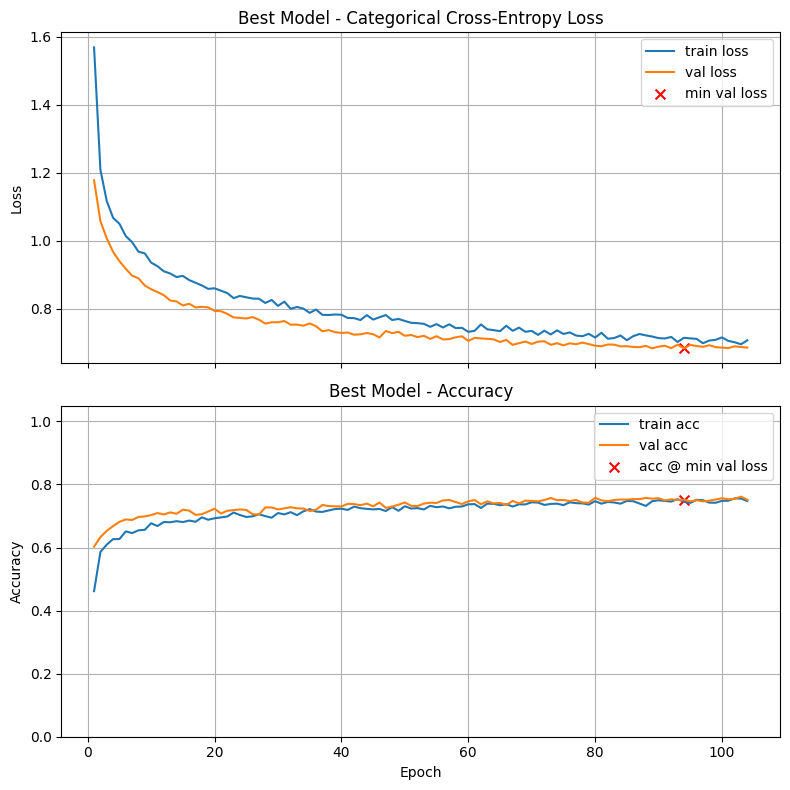

Final Training Loss:            0.7064
Final Training Accuracy:        0.7474
Final Validation Loss:          0.6850
Final Validation Accuracy:      0.7514
Minimum Validation Loss:        0.6827 (Epoch 94)
Validation Accuracy @ Min Loss: 0.7514

Test Loss: 0.7109
Test Accuracy: 0.7486

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:22


In [51]:
#use one more layer w/ width = 128
def build_best_model():
    model = build_model(X_train.shape[-1],
                        [(128, best_activation, best_l2_1, best_d1),
                         (62, best_activation, best_l2_1, best_d2),
                         (32, best_activation, best_l2_2, max(0.0, best_d2-0.1))],
                         n_classes)
    return model
#add lr scheduler
lr_sched = ExponentialDecay(
    initial_learning_rate = best_lr,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=False
)
#train model
results = {}
best_model = build_best_model()
hist = train_and_test(
    best_model,
    lr_schedule=lr_sched,
    batch_size=64,
    title="Best Model",
    return_history=True
)


Best Model



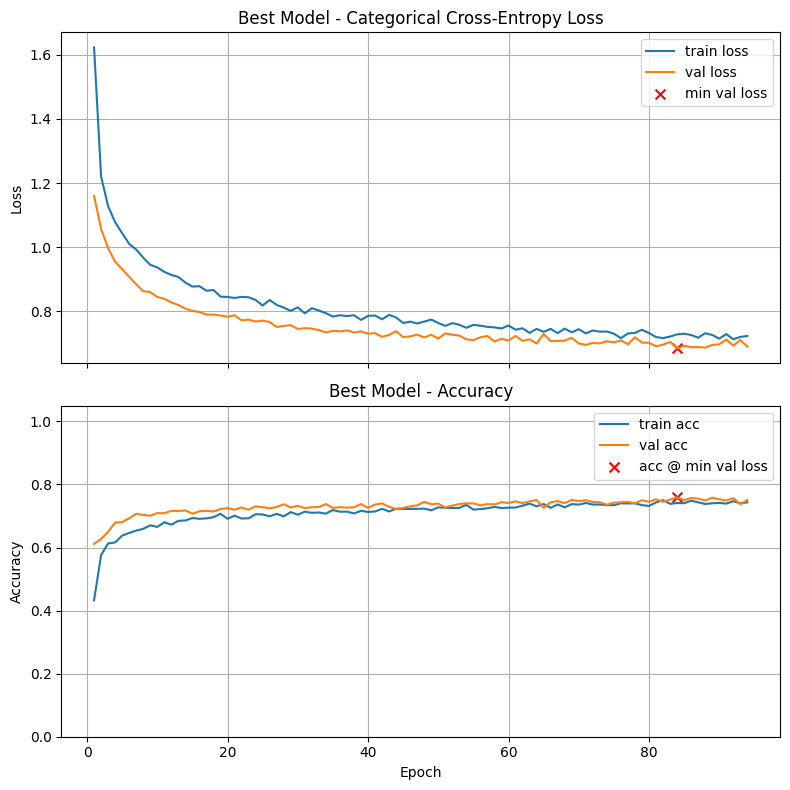

Final Training Loss:            0.7234
Final Training Accuracy:        0.7433
Final Validation Loss:          0.6902
Final Validation Accuracy:      0.7507
Minimum Validation Loss:        0.6848 (Epoch 84)
Validation Accuracy @ Min Loss: 0.7593

Test Loss: 0.7174
Test Accuracy: 0.7436

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:20


In [56]:
#rerun w/o lr_sched
def build_best_model():
    model = build_model(X_train.shape[-1],
                        [(128, best_activation, best_l2_1, best_d1),
                         (62, best_activation, best_l2_1, best_d2),
                         (32, best_activation, best_l2_2, max(0.0, best_d2-0.1))],
                         n_classes)
    return model
#train model
results = {}
best_model = build_best_model()
hist = train_and_test(
    best_model,
    lr_schedule=best_lr,
    batch_size=64,
    title="Best Model",
    return_history=True
)

In [57]:
#find best val. accuracy
best_title, (best_acc, best_epoch) = max(results.items(), key=lambda kv: kv[1][0])
print("Best val accuracy:", best_acc)

Best val accuracy: 0.7592856884002686


In [58]:
# Set a6 to the validation accuracy found by this best model
#model without lr sched. got better accuracy
a6 = best_acc             # Replace 0.0 with your answer

In [59]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.7593


### Optional: Print out your results of all experiments

In [60]:
print_results()

Best Model                              	0.7593


## Reflection Questions (ungraded)

It would be a great idea to think through your answers to these questions, then give ChatGPT (or other AI tool) a PDF of your
homework, and **discuss** (not just ask) these. 

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?